In [ ]:
# Importiere Module

In [1]:
import tensorflow as tf
import sys
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
import h5py
import math
from random import randint, shuffle

In [3]:
#Preprocess Data

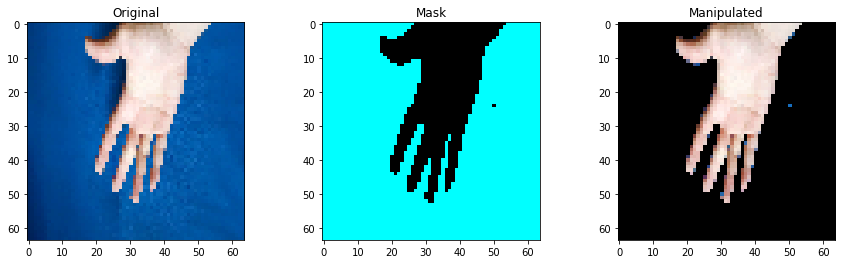

In [6]:
path = os.path.join("Samples", "video.mp4")
cap = cv2.VideoCapture(path)
test = cap.read()

thresh_min = 20


out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (64,64))


frame = 0
for _ in range(75):
    ret, frame = cap.read()

    
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = cv2.resize(frame, (64,64))

retval, thresh = cv2.threshold(frame, thresh_min, 255, cv2.THRESH_BINARY)


thresh[np.where((thresh != [0,0,0]).all(axis=2))] = 0


z = np.zeros(frame.shape, dtype=np.uint8)
counter = 0
for x in range(z.shape[0]):
    for y in range(z.shape[1]):
        
        tmp = thresh[x][y]
        #print(tmp)
        
        if np.all(tmp == [0,0,0]):
            z[x][y] = frame[x][y]
            counter+=1

# Plotten
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(frame ,cmap=plt.get_cmap('gray'))
plt.title("Original")
           
plt.subplot(1, 3, 2)
plt.imshow(thresh, cmap=plt.get_cmap('gray'))
plt.title("Mask")

plt.subplot(1, 3, 3)
plt.imshow(z, cmap=plt.get_cmap('gray'))
plt.title("Manipulated")
plt.show() 

In [8]:
resize_shape = (64,64)

path = os.path.join("Samples", "video.mp4")
cap = cv2.VideoCapture(path)
test = cap.read()

out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30, resize_shape)

while(True):
    ret, frame = cap.read()

    if ret == True: 
        # My Code
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        retval, thresh = cv2.threshold(frame, thresh_min, 255, cv2.THRESH_BINARY)
        thresh[np.where((thresh != [0,0,0]).all(axis=2))] = 0
        frame = cv2.resize(frame, resize_shape)
        thresh = cv2.resize(thresh, resize_shape)

        z = np.zeros(frame.shape, dtype=np.uint8)

        for x in range(z.shape[0]):
            for y in range(z.shape[1]):

                tmp = thresh[x][y]

                if np.all(tmp == [0,0,0]):
                    z[x][y] = frame[x][y]


        z = cv2.cvtColor(z, cv2.COLOR_RGB2BGR)

        cv2.imshow('frame',frame)
        cv2.imshow("z", z)

        # Write the frame into the file 'output.avi'
        out.write(z)

        # Display the resulting frame    

        # Press Q on keyboard to stop recording
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Break the loop
    else:
        break 


cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
# Generate Training set as hdf5

Shuffling
Trainingsdataset shape: (19859, 64, 64)


<Figure size 432x288 with 0 Axes>

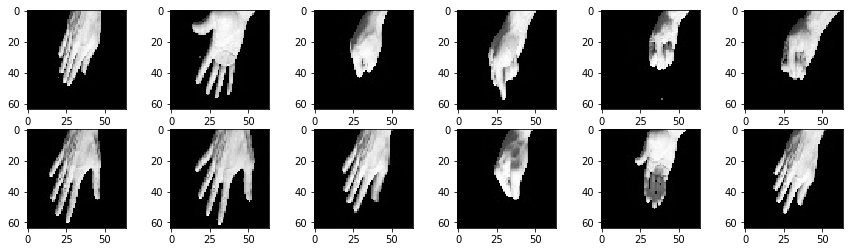

In [65]:
path = os.path.join("outpy.avi")
cap = cv2.VideoCapture(path)

loop, data = cap.read()

data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
data = cv2.cvtColor(data, cv2.COLOR_RGB2GRAY)
x_dataset = np.array([data], dtype=np.float32)

with h5py.File("Rnvironment/dataset.hdf5", "a") as f:
    f.create_dataset("training", data=x_dataset , maxshape=(None,64,64),dtype=np.float32, chunks=True)
    
    
    while(True):
        loop, data = cap.read()

        if(loop):
            data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
            data = cv2.cvtColor(data, cv2.COLOR_RGB2GRAY)
            x_dataset = np.array([data], dtype=np.float32)
            
            f["training"].resize((f["training"].shape[0]+1, 64,64),)
            
            f["training"][-1] = x_dataset
            
            f.flush()
            
            #print(data.shape)
            #x_dataset = np.append(x_dataset, np.array([data]), axis=0)
        else:
            print("Shuffling started...")
            shuffle(f["training"])
            break

    print("Trainingsdataset shape:", f["training"].shape)


#plt.imshow(x_dataset[0], cmap=plt.get_cmap('gray'))
plt.figure(figsize=(15, 4))
with h5py.File("dataset.hdf5", "r") as f:
    for i in range(12):
        randVal = randint(0,f["training"].shape[0]-1)
        plt.subplot(2, 6, i+1)
        plt.imshow(f["training"][randVal],cmap=plt.get_cmap('gray'))
plt.show()

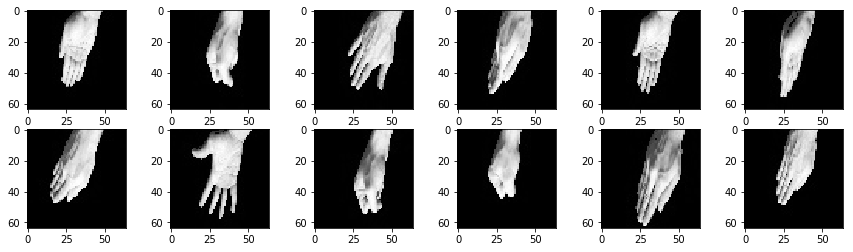

In [66]:
plt.figure(figsize=(15, 4))
with h5py.File("dataset.hdf5", "r") as f:
    for i in range(12):
        randVal = randint(0,f["training"].shape[0]-1)
        plt.subplot(2, 6, i+1)
        plt.imshow(f["training"][i],cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
# Load Trainig Data

In [5]:
dset_file = h5py.File("Environment/dataset.hdf5", "r")
x_dataset = dset_file["training"]
dset_shape = dset_file["training"].shape
input_shape = dset_file["training"][0].shape
print("Datasetshape:", dset_shape)
print("Input shape:", input_shape)

Datasetshape: (19859, 64, 64)
Input shape: (64, 64)


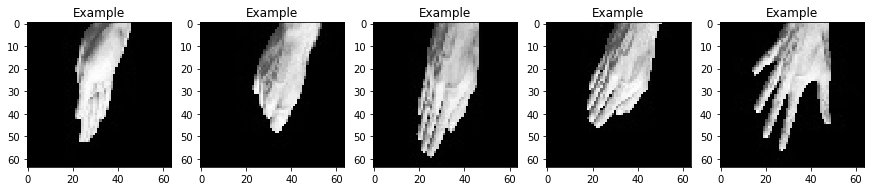

In [85]:
def getRandomImages(d_set,anzahl):
    bla = randint(0, d_set.shape[0]-1)
    x_sample = np.array([d_set[bla].reshape(input_shape[0], input_shape[1], 1)], dtype=np.float32)
    
    for k in range(anzahl-1):
        bla = randint(0, d_set.shape[0]-1)
        x_sample = np.append(x_sample,  np.array([d_set[bla].reshape(input_shape[0], input_shape[1], 1)]), axis = 0)
    return x_sample      

def getBatch(x_dataset, batchSize, pointer):
    shape = x_dataset.shape[0]
    if pointer+batch_size < shape:
        tmp = pointer
        pointer += batchSize
        return (x_dataset[tmp:pointer],pointer)
    else:
        tmp = 0
        pointer += batchSize
        return (x_dataset[tmp:batchSize], tmp)
    

randSample = getRandomImages(x_dataset, 5)
plt.figure(figsize=(15,6))
for haha in range(5):
    plt.subplot(1, 5, haha+1)
    plt.imshow(randSample[haha].reshape(input_shape[0],input_shape[1]),cmap=plt.get_cmap('gray'))
    plt.title("Example")
    num = 0 

In [455]:
# Train Autoencoder

In [ ]:
##############################################################
# Der Rest in dem Notebook ist eine alte Version in dem der  #
# Fehlerterm von dem Autoencoder falsch implementiert wurde. #
# Die Resultate sind eher bescheiden und dient eher als ein  #
# Lernexperiment. Der eigentliche bessere Code ist in dem    #
# Environment Folder und die einzelnen Module sind           #
# entsprechend gekapselt. Das Model ist in Model.py und in   #
# dem GeneratedImage Folder sind die generierten Bilder von  #
# von jeweils 12 verschiedenen Bildern. Der Name des Bildes  #
# ist die Typnummer, die Anzahl der Dimension z und die      #
# Epoche (also wie oft der gesamte Datenbestand einmal       #
# durchlaufen wurde)                                         #
##############################################################

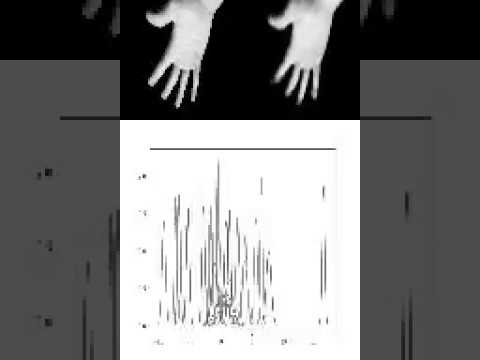

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('P85sRAGyZvQ')

Das folgende Video gibt einen guten Überblick über Autoencoder (ca. 15 min)
und gibt ein paar Beispielapplikationen


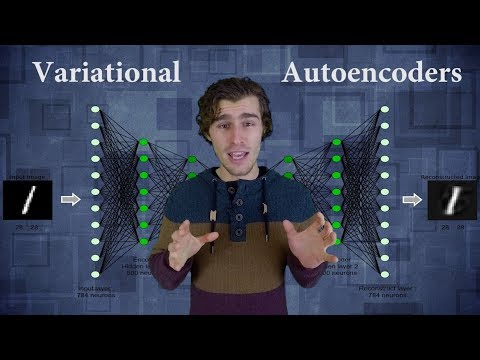

In [13]:
print("Das folgende Video gibt einen guten Überblick über Autoencoder (ca. 15 min)\nund gibt ein paar Beispielapplikationen")
YouTubeVideo('9zKuYvjFFS8')

In [108]:
### Anzahl der latenten Eigenschaften
n_z = 12

In [110]:
## Netzwerk
tf.reset_default_graph()


x = tf.placeholder("float", shape=[None, input_shape[0],input_shape[1],1], name="input")

W1 = tf.get_variable("w1", shape=[4, 4, 1, 8], initializer=tf.contrib.layers.xavier_initializer())
Z1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='SAME', name="Z1")
A1 = tf.nn.relu(Z1, name="A1")
P1 = tf.nn.avg_pool(A1, ksize=[1,2,2,1], strides=[1,1,1,1], padding="SAME", name="P1")


W2 = tf.get_variable("w2", shape=[4, 4, 8, 16], initializer=tf.contrib.layers.xavier_initializer())
Z2 = tf.nn.conv2d(P1, W2, strides=[1, 2, 2, 1], padding='SAME', name="Z2")
A2 = tf.nn.relu(Z2, name="A2")
P2 = tf.nn.avg_pool(A2, ksize=[1,2,2,1], strides=[1,1,1,1], padding="SAME", name="P2")


W3 = tf.get_variable("w3", shape=[4, 4, 16, 16], initializer=tf.contrib.layers.xavier_initializer())
Z3 = tf.nn.conv2d(P2, W3, strides=[1, 2, 2, 1], padding='SAME', name="Z3")
A3 = tf.nn.relu(Z3, name="A3")
P3 = tf.nn.avg_pool(A3, ksize=[1,2,2,1], strides=[1,1,1,1], padding="SAME", name="P3")  # FailFish

f3 = tf.contrib.layers.flatten(P3)

f4 = tf.contrib.layers.fully_connected(f3, 1000, activation_fn=tf.nn.relu)

z_mean = tf.contrib.layers.fully_connected(f4, n_z, activation_fn=None)
z_log_sigma_sq = tf.contrib.layers.fully_connected(f4, n_z, activation_fn=None)


eps = tf.random_normal((tf.shape(x)[0], n_z), 0, 1, dtype=tf.float32, name="eps") # Adding a random number
z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps), name="z")  # The sampled z

d_A1 = tf.contrib.layers.fully_connected(z, 8*8*128, activation_fn=tf.nn.relu)

#d_A2 = tf.contrib.layers.fully_connected(d_A1, 4096, activation_fn=tf.nn.relu)


d_Z1tmp = tf.reshape(d_A1, [tf.shape(z)[0], 8, 8, 128])


d_1Conv = tf.layers.conv2d_transpose(d_Z1tmp, 64, 5, strides=2, padding="same")
d_1Conv = tf.layers.batch_normalization(d_1Conv)
d_1Conv = tf.nn.softmax(d_1Conv)

d_2Conv = tf.layers.conv2d_transpose(d_1Conv, 32, 5, strides=2, padding="same")
d_2Conv = tf.layers.batch_normalization(d_2Conv)
d_2Conv = tf.nn.softmax(d_2Conv)

d_3Conv = tf.layers.conv2d_transpose(d_2Conv, 1, 5, strides=2, padding="same")
d_3Conv = tf.layers.batch_normalization(d_3Conv)
d_3Sigmoid_before_pooling = tf.nn.sigmoid(d_3Conv, name="result_sigmoid")

print(d_3Sigmoid_before_pooling)

### Old
#d_1 = tf.image.resize_images(d_Z1tmp, (32,32), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#d_1Conv = tf.layers.conv2d(d_1, filters=16, kernel_size=(3,3), padding="same",activation=tf.nn.relu)
#d_P1 = tf.nn.avg_pool(d_1Conv, ksize=[1,2,2,1], strides=[1,1,1,1], padding="SAME")


#d_2 = tf.image.resize_images(d_P1, (48,48), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#d_2Conv = tf.layers.conv2d(d_2, filters=16, kernel_size=(2,2), padding="same",activation=tf.nn.relu)
#d_P2 = tf.nn.avg_pool(d_2Conv, ksize=[1,2,2,1], strides=[1,1,1,1], padding="SAME")


#d_3tmp = tf.image.resize_images(d_P2, (64,64), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#d_3Conv = tf.layers.conv2d(d_3tmp, filters=1, kernel_size=(2,2), padding="same",activation=None, name="result_before_pool")


#Branches
#d_3Sigmoid_before_pooling = tf.nn.sigmoid(d_3Conv, name="result_before_pool")
#d_P3 = tf.nn.avg_pool(d_3Conv, ksize=[1,2,2,1], strides=[1,1,1,1], padding="SAME", name="d_P3")
#d_3Sigmoid_after_pooling = tf.nn.sigmoid(d_P3, name="result_after_pool")
###

## Model Infos

"""
print(x)
print(P1)
print(P2)
print(P3)
print(f3)
print(f4)
print(z_mean)
print(z_log_sigma_sq)
print(z)
print(d_A1)
print(d_A2)
print(d_Z1tmp)
print(d_P1)
print(d_P2)
print(d_3Sigmoid_before_pooling)
print(d_3Sigmoid_after_pooling)
"""


Tensor("result_sigmoid:0", shape=(?, 64, 64, 1), dtype=float32)


'\nprint(x)\nprint(P1)\nprint(P2)\nprint(P3)\nprint(f3)\nprint(f4)\nprint(z_mean)\nprint(z_log_sigma_sq)\nprint(z)\nprint(d_A1)\nprint(d_A2)\nprint(d_Z1tmp)\nprint(d_P1)\nprint(d_P2)\nprint(d_3Sigmoid_before_pooling)\nprint(d_3Sigmoid_after_pooling)\n'

In [113]:
# Cost function
x_reconstr_mean_ = tf.clip_by_value(d_3Sigmoid_before_pooling, 1e-7, 1-1e-7)
print(x_reconstr_mean_)
print(x)
reconstr_loss = -tf.reduce_sum(x * tf.log(1e-10 + x_reconstr_mean_) + (1-x) * tf.log(1e-10 + 1 - x_reconstr_mean_), 1)
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1)
cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch

# Use ADAM optimizer
optimizer =  tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

Tensor("clip_by_value:0", shape=(?, 64, 64, 1), dtype=float32)
Tensor("input:0", shape=(?, 64, 64, 1), dtype=float32)


(19859, 64, 64)
(1, 64, 64, 1)


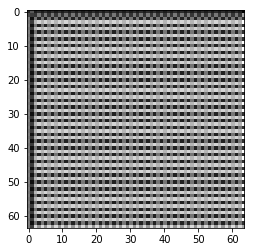

In [114]:
with tf.Session() as sess_test:
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print(x_dataset.shape)
    ## Test runs
    t, t2 = sess_test.run([d_3Sigmoid_before_pooling, z], feed_dict={z: np.zeros((1,n_z)), x: x_dataset[2:3].reshape(-1,input_shape[0],input_shape[1],1)/255})

    #t, t2 = sess_test.run([d_3Sigmoid_after_pooling, z], feed_dict={z: np.zeros((2,n_z))})
    t, t2 = sess_test.run([d_3Sigmoid_before_pooling, z], feed_dict={z: np.zeros((4,n_z))})
    t = sess_test.run(d_3Sigmoid_before_pooling, feed_dict={x: x_dataset[2:3].reshape(-1,input_shape[0],input_shape[1],1)/255})
    print(t.shape)
    
plt.imshow(t.reshape(input_shape[0],input_shape[1])*255,cmap=plt.get_cmap('gray'))

Test run after starting [81113330.0]
Epoch: 0001 cost= 30392.562506782
Model saved in file: model/modelHandConv0.ckpt


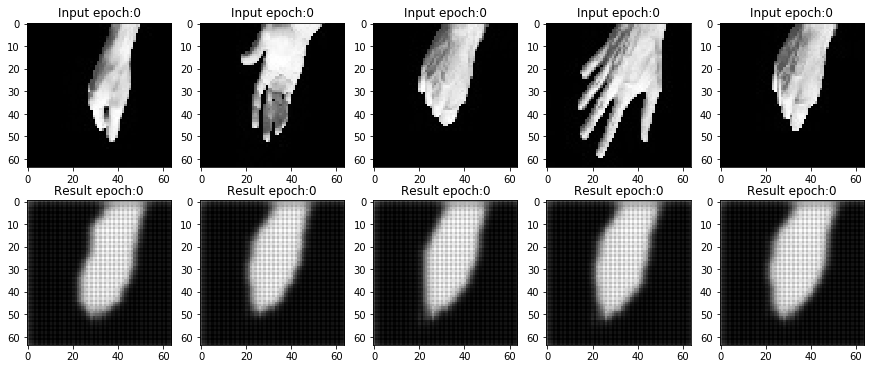

Epoch: 0002 cost= 17176.131218804
Epoch: 0003 cost= 16171.465348985
Epoch: 0004 cost= 15917.101779514
Epoch: 0005 cost= 15785.138868544
Epoch: 0006 cost= 15682.885969374


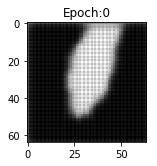

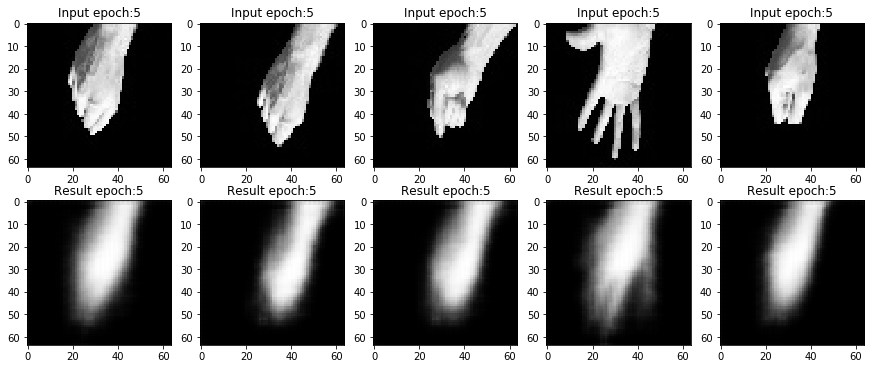

Epoch: 0007 cost= 15662.154981825
Epoch: 0008 cost= 15636.486690945
Epoch: 0009 cost= 15591.640614827
Epoch: 0010 cost= 15578.059912788
Epoch: 0011 cost= 15579.818637424


<Figure size 1080x1080 with 0 Axes>

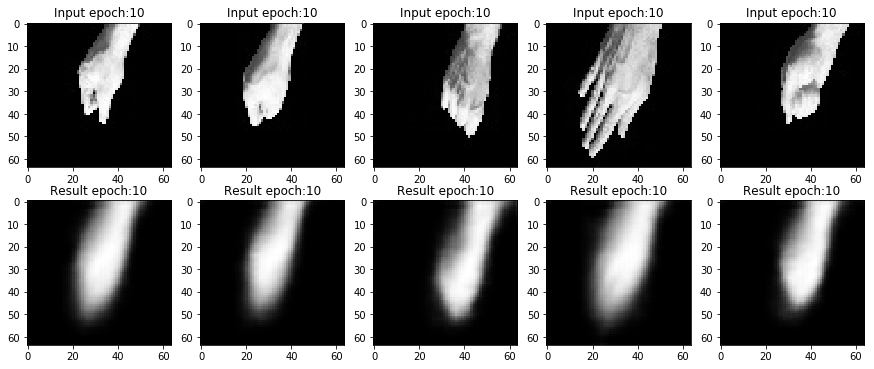

Epoch: 0012 cost= 15561.555257161
Epoch: 0013 cost= 15562.161851671
Epoch: 0014 cost= 15552.643690321
Epoch: 0015 cost= 15543.793297662
Epoch: 0016 cost= 15541.295803494


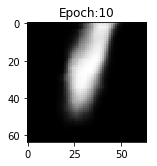

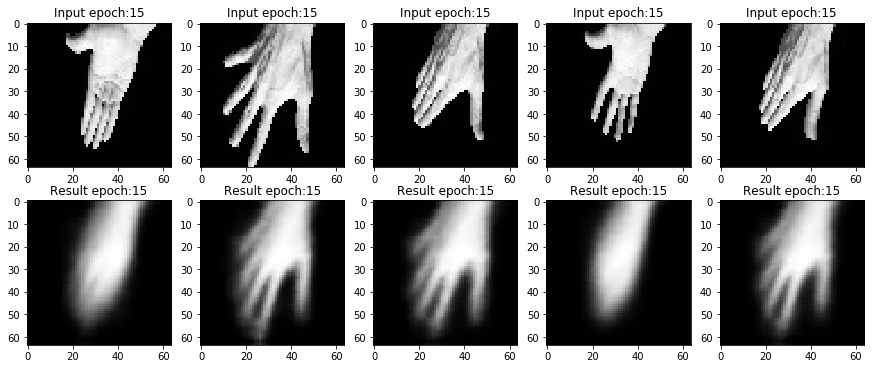

Epoch: 0017 cost= 15536.532908122
Epoch: 0018 cost= 15524.599568685
Epoch: 0019 cost= 15520.520019531
Epoch: 0020 cost= 15517.173387316
Epoch: 0021 cost= 15504.738718669


<Figure size 1080x1080 with 0 Axes>

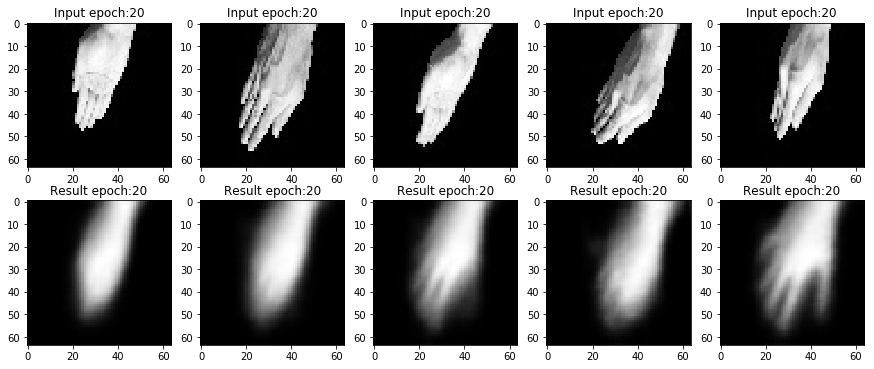

Epoch: 0022 cost= 15509.822835286
Epoch: 0023 cost= 15509.468841553
Epoch: 0024 cost= 15501.988630507
Epoch: 0025 cost= 15506.395378961
Epoch: 0026 cost= 15511.751112196


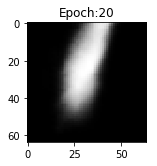

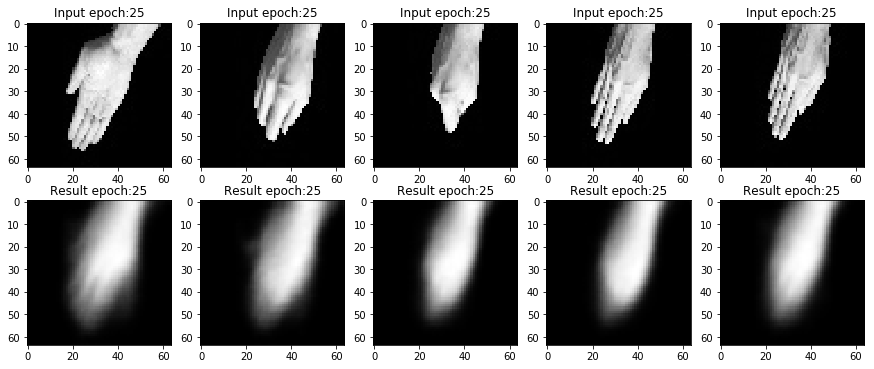

KeyboardInterrupt: 

<Figure size 1080x1080 with 0 Axes>

In [115]:
## Train Hand Autoencoder Model
runs =  301
pointer = 0
num = 0
cost_tracker = {}

init = tf.initialize_all_variables()
saver = tf.train.Saver()
batch_size = 64
with tf.Session() as sess:
    sess.run(init)
    batch_xs, pointer = getBatch(x_dataset, batch_size, pointer)
    
    batch_xs = batch_xs.reshape(batch_size,input_shape[0],input_shape[1],1)

    dd = sess.run([cost], feed_dict={x: batch_xs})
    print('Test run after starting {}'.format(dd))
    

    for epoch in range(runs):
        avg_cost = 0.
        
        num_of_batches = x_dataset.shape[0]/batch_size
        num_of_batches = int(num_of_batches)
        
        
        # Loop over all batches
        for i in range(num_of_batches):
            batch_xs, pointer = getBatch(x_dataset, batch_size, pointer)
            batch_xs = batch_xs.reshape(batch_size,input_shape[0],input_shape[1],1)
            
            batch_xs = batch_xs/255
            
            _,d = sess.run((optimizer, cost), feed_dict={x: batch_xs})
            avg_cost += d / 18 * batch_size
        
        cost_tracker[epoch] = avg_cost
        # Display logs per epoch step
        if epoch % 1 == 0:
            save_path = saver.save(sess, "model/modelHandConv.ckpt")
            #print("Model saved in file: {}".format(save_path))
            print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
        
        if epoch % 50 == 0:
            save_path = saver.save(sess, "model/modelHandConv{}.ckpt".format(epoch))
            print("Model saved in file: model/modelHandConv{}.ckpt".format(epoch))
            #print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
            
            
        ## zum plotten der einzelnen results der epochs
        if(epoch % 5 == 0):
            plt.show()
            randSample = getRandomImages(x_dataset, 5)/255
            resultPlot = sess.run((d_3Sigmoid_before_pooling), feed_dict={x: randSample})
            plt.figure(figsize=(15,6))
            for haha in range(5):
                plt.subplot(2, 5, haha+1)
                plt.imshow(randSample[haha].reshape(input_shape[0],input_shape[1])*255,cmap=plt.get_cmap('gray'))
                plt.title("Input epoch:{}".format(epoch))
                num = 0 
            for haha in range(5):
                plt.subplot(2, 5, haha+6)
                plt.imshow(resultPlot[haha].reshape(input_shape[0],input_shape[1])*255,cmap=plt.get_cmap('gray'))
                plt.title("Result epoch:{}".format(epoch))
                num = 0 
            plt.show()
            plt.figure(figsize=(15,15))
        
        
        if(epoch % 10 == 0):
            plt.subplot(1, 6, int((epoch%50)/10)+1)
            randSample = getRandomImages(x_dataset, 1)/255
            resultPlot = sess.run((d_3Sigmoid_before_pooling), feed_dict={x: randSample})
            plt.imshow(resultPlot.reshape(input_shape[0],input_shape[1])*255,cmap=plt.get_cmap('gray'))
            plt.title("Epoch:{}".format(epoch))
            num +=1

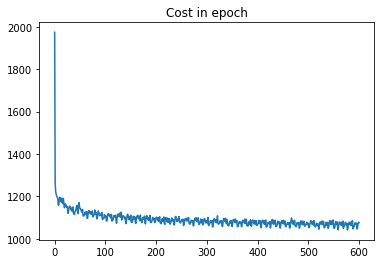

In [91]:
cost_tracker
cost_tracker_values = []
for blablabla in range(len(cost_tracker)):
    cost_tracker_values.append(cost_tracker[blablabla])

plt.plot(range(len(cost_tracker)), cost_tracker_values)
plt.title("Cost in epoch")
plt.show()

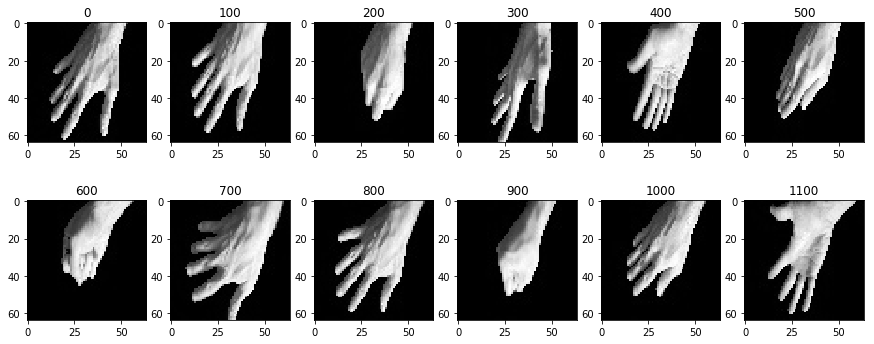

In [16]:
# Choose a Baseline
plt.figure(figsize=(15, 6))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.title(i*100)
    plt.imshow(x_dataset[i*100],cmap=plt.get_cmap('gray'))
plt.show()

INFO:tensorflow:Restoring parameters from model/modelHandConv600.ckpt
Model restored.


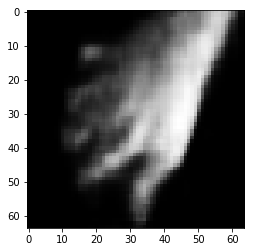

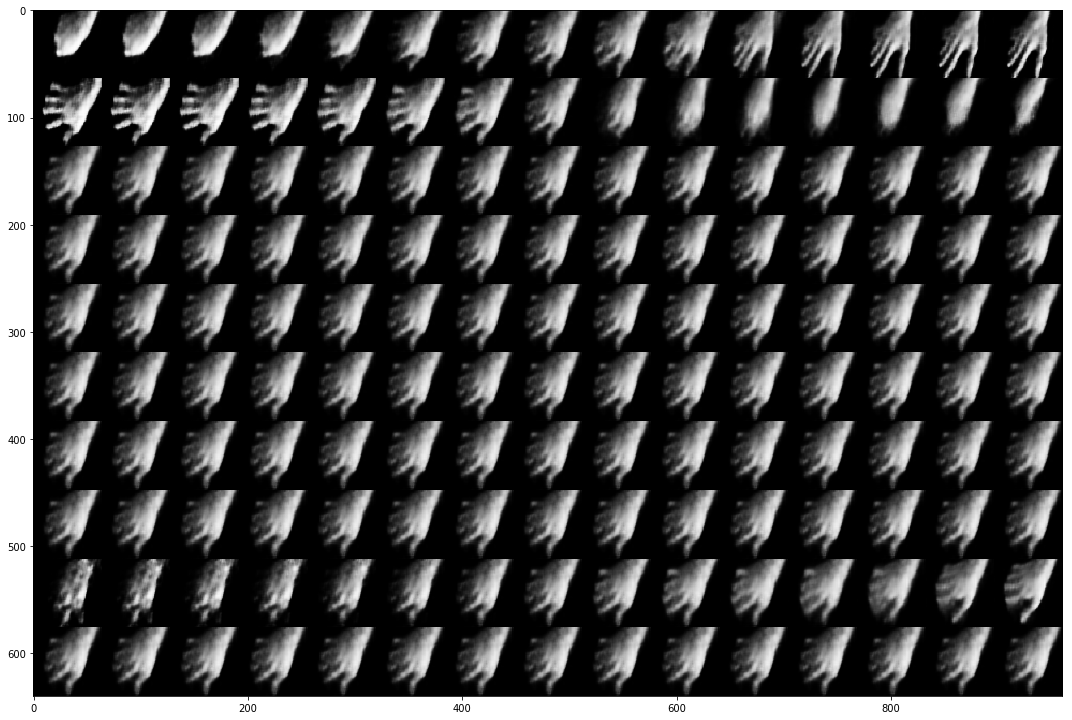

In [66]:
wahl = 700

check_point_file = "model/modelHandConv600.ckpt"

with tf.Session() as sess:
    saver.restore(sess, check_point_file)
    print("Model restored.")
    z_baseline  = sess.run((z), feed_dict={x: x_dataset[wahl].reshape(1,input_shape[0], input_shape[1], 1)/255})
    resultImage = sess.run((d_3Sigmoid_before_pooling), feed_dict={z: z_baseline})
    
    resultImage = resultImage.reshape(input_shape[0], input_shape[1])*255
    plt.imshow(resultImage, cmap=plt.get_cmap('gray'))
    plt.show()

    ######## Plotten der Latenten Eigenschaften
    nx = 15
    ny = n_z
    x_values = np.linspace(-3, 3, nx)
    canvas = np.empty((input_shape[0]*ny, input_shape[1]*nx))
    for i in range(ny):
        z_latent = z_baseline
        
        # Create input Matrix with altered xvalues in the i-th feature
        z_latent = np.ones((nx,ny))*z_latent
        z_latent[:,i] += x_values.transpose()
        
        resultImage = sess.run(d_3Sigmoid_before_pooling, feed_dict={z: z_latent})
        
        for canvasRow in range(nx):
            canvas[(i)*input_shape[0]:(i+1)*input_shape[1], canvasRow*input_shape[0]:(canvasRow+1)*input_shape[1]] = resultImage[canvasRow].reshape(input_shape[0], input_shape[1])

    plt.figure(figsize=(15, 15))        
    plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
    plt.tight_layout()



INFO:tensorflow:Restoring parameters from model/modelHandConv600.ckpt
Model restored.


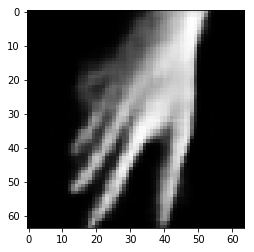

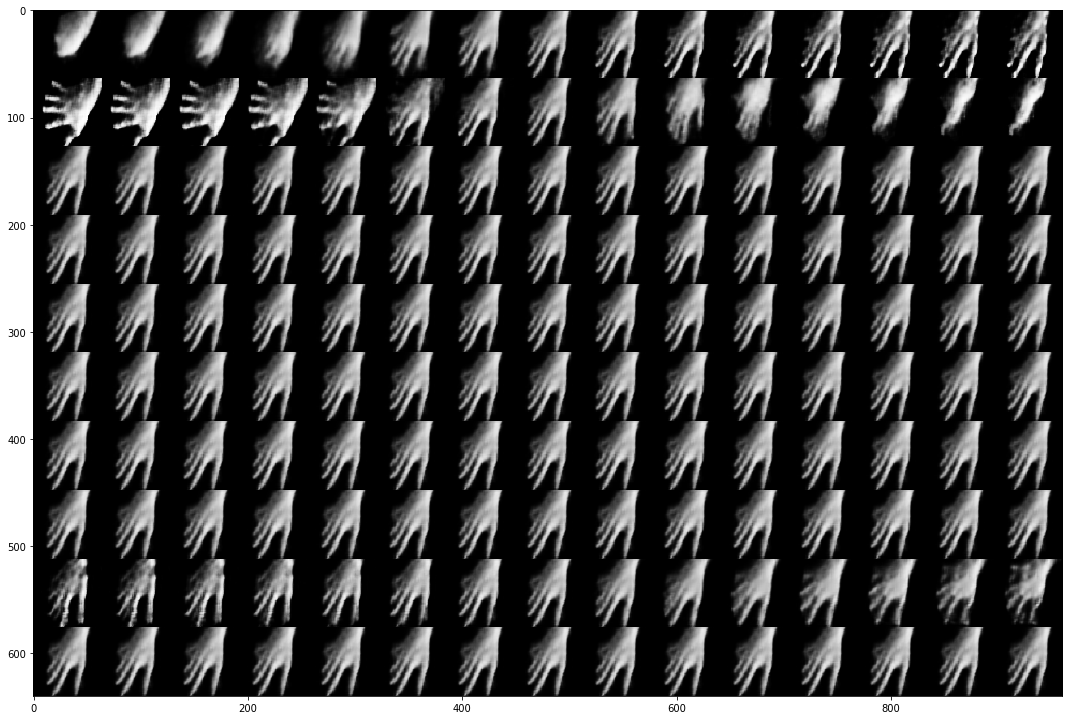

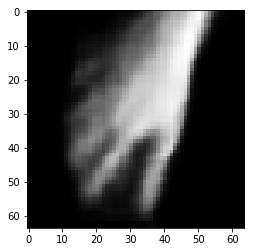

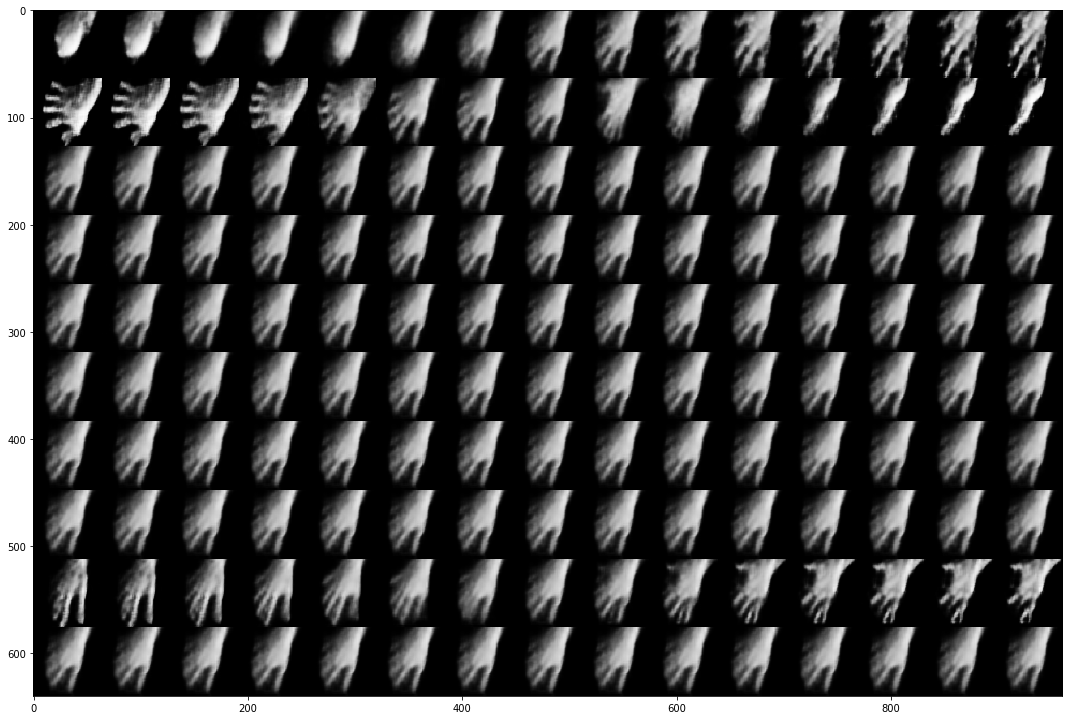

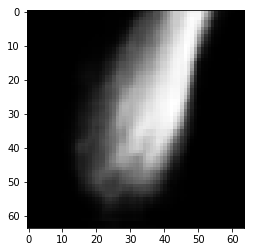

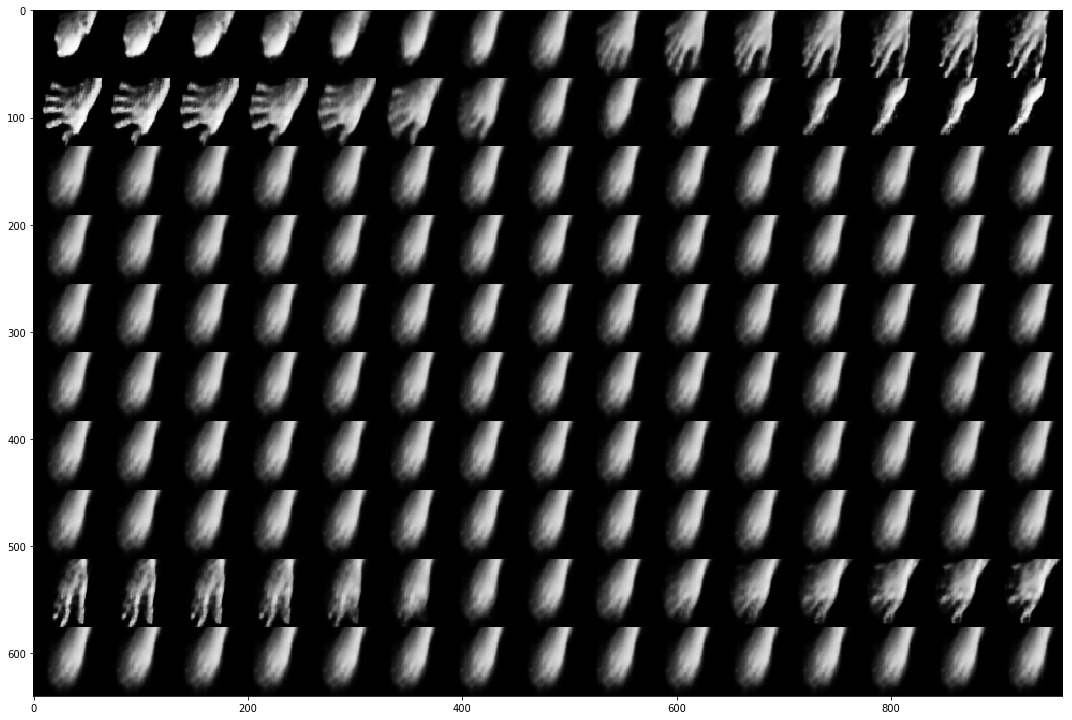

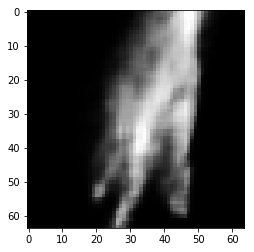

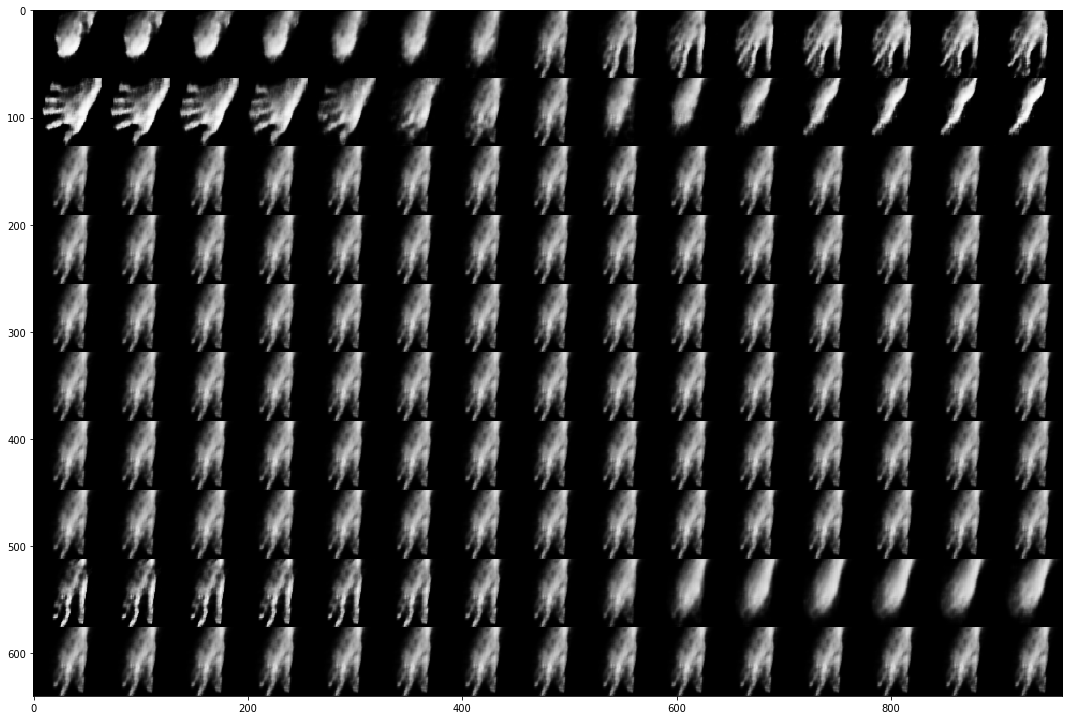

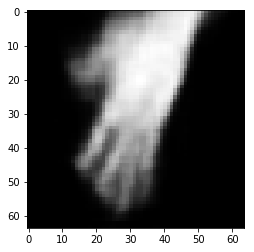

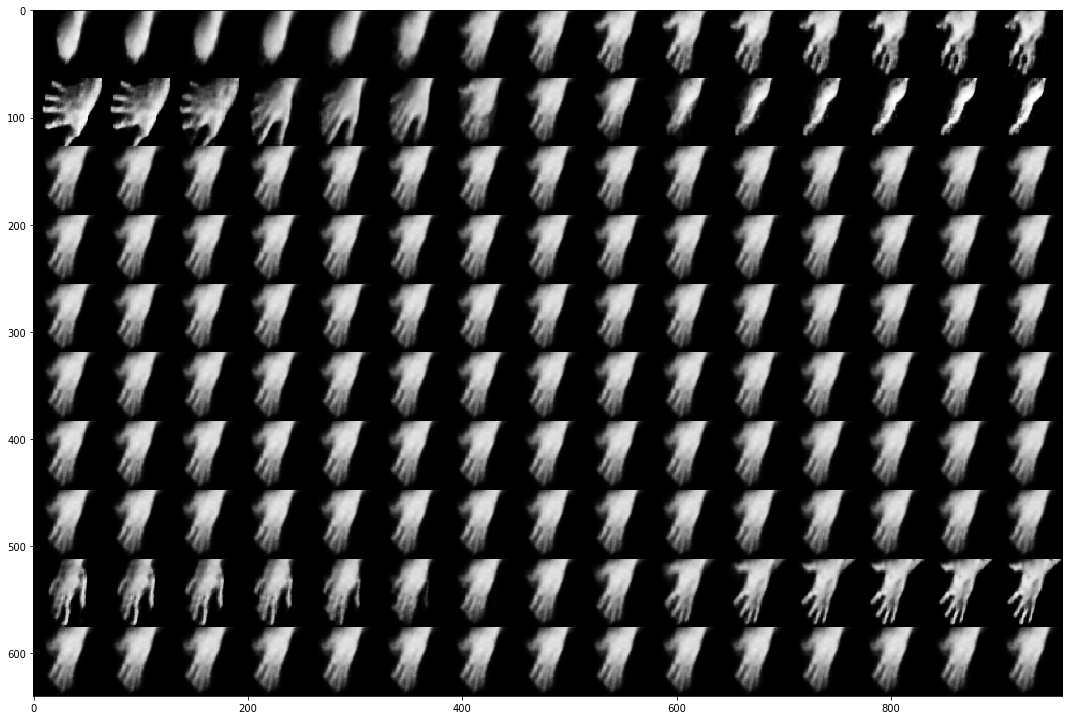

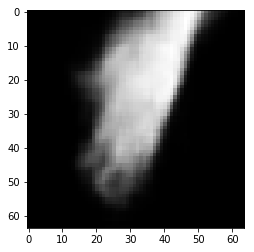

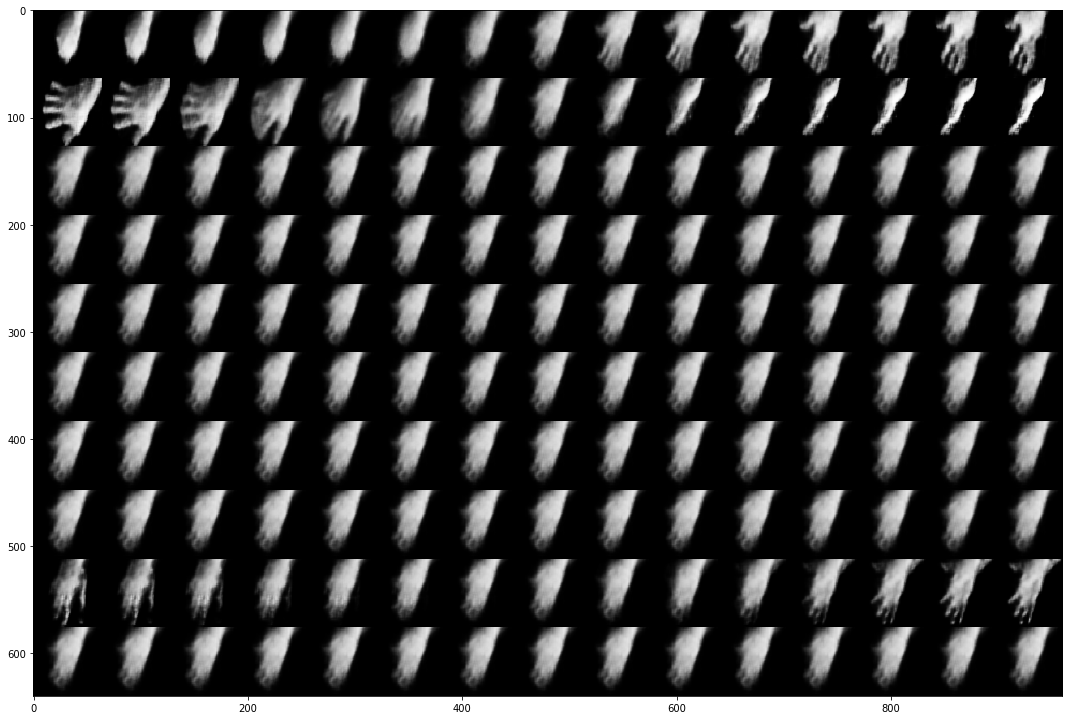

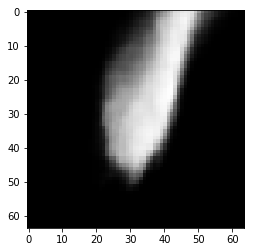

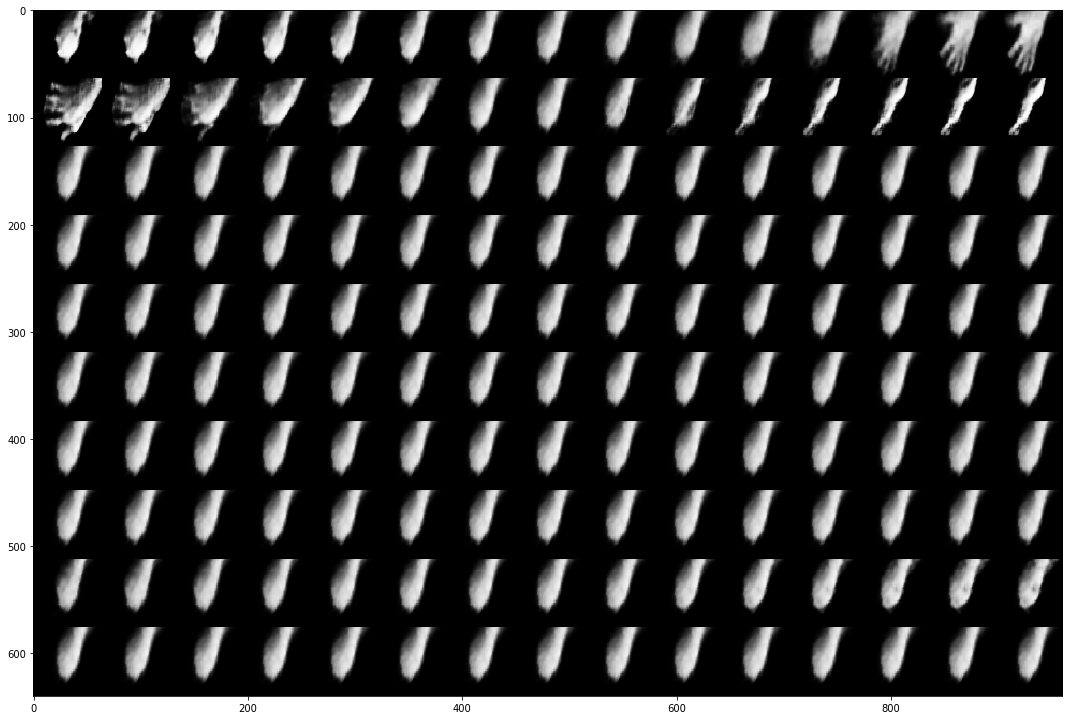

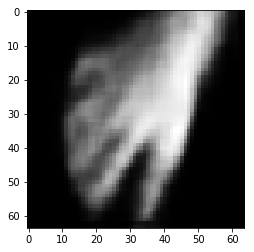

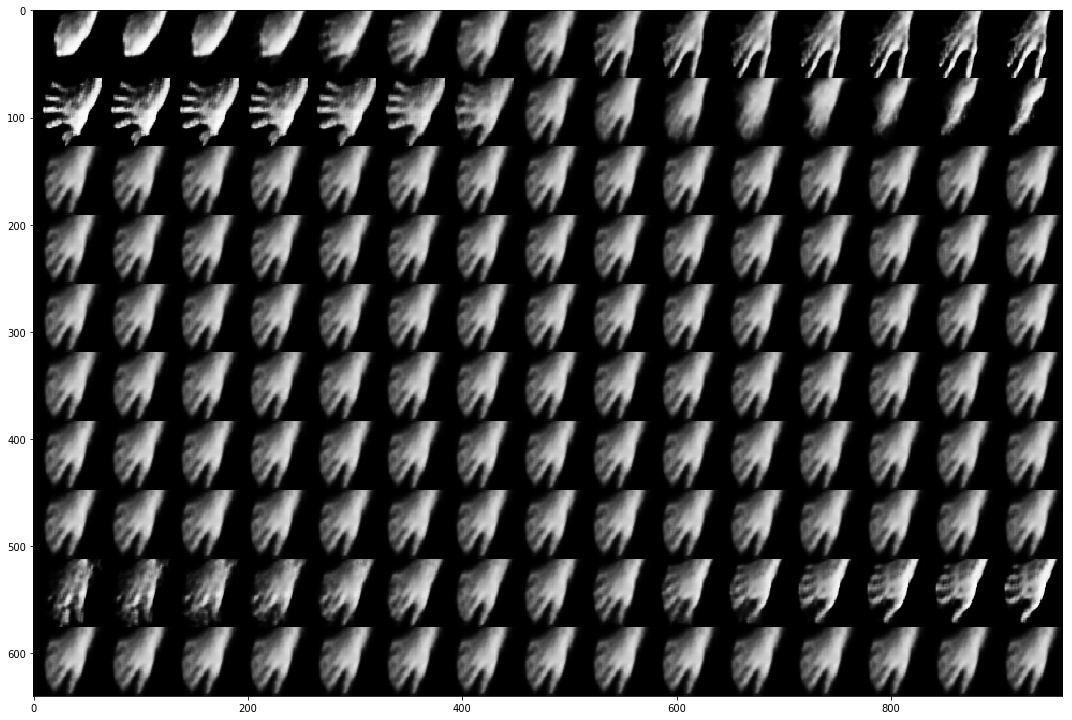

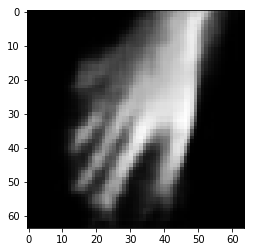

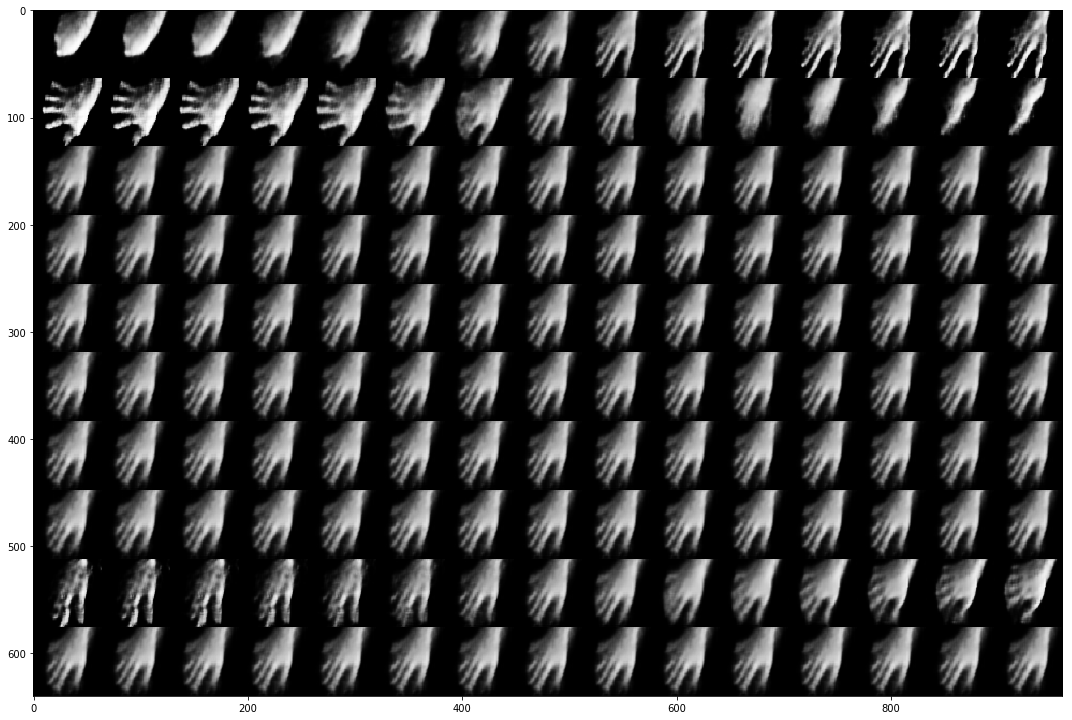

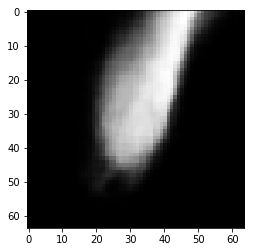

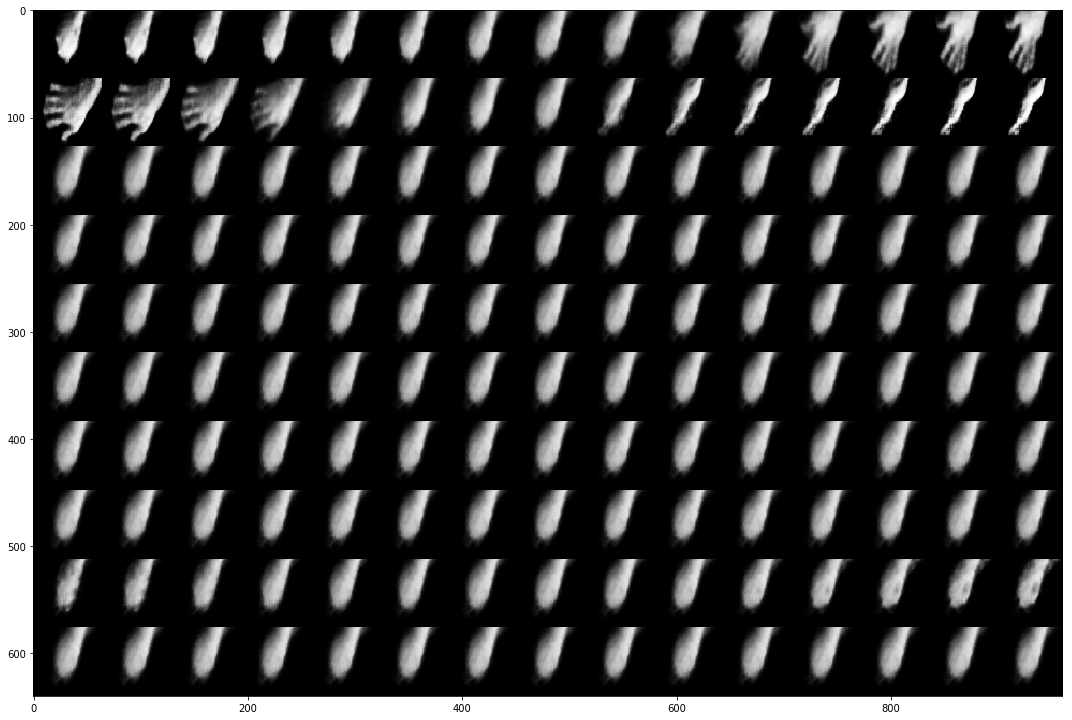

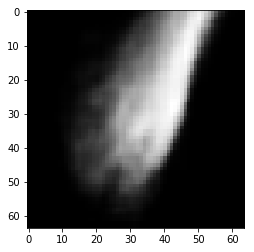

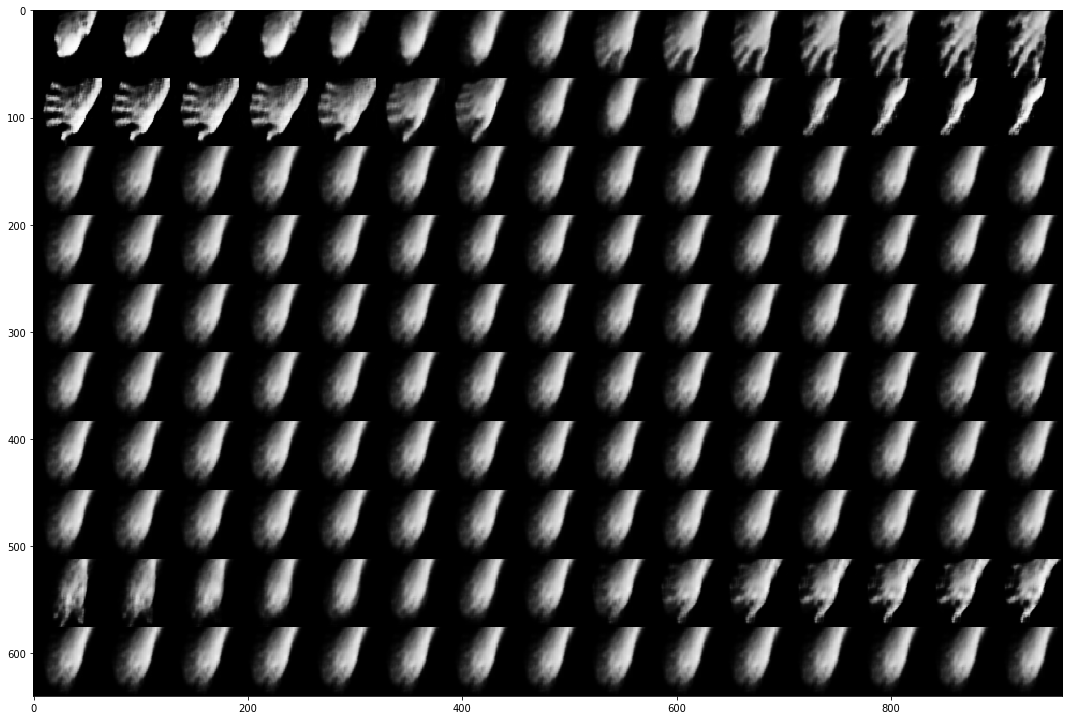

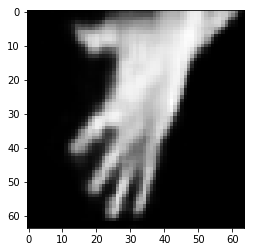

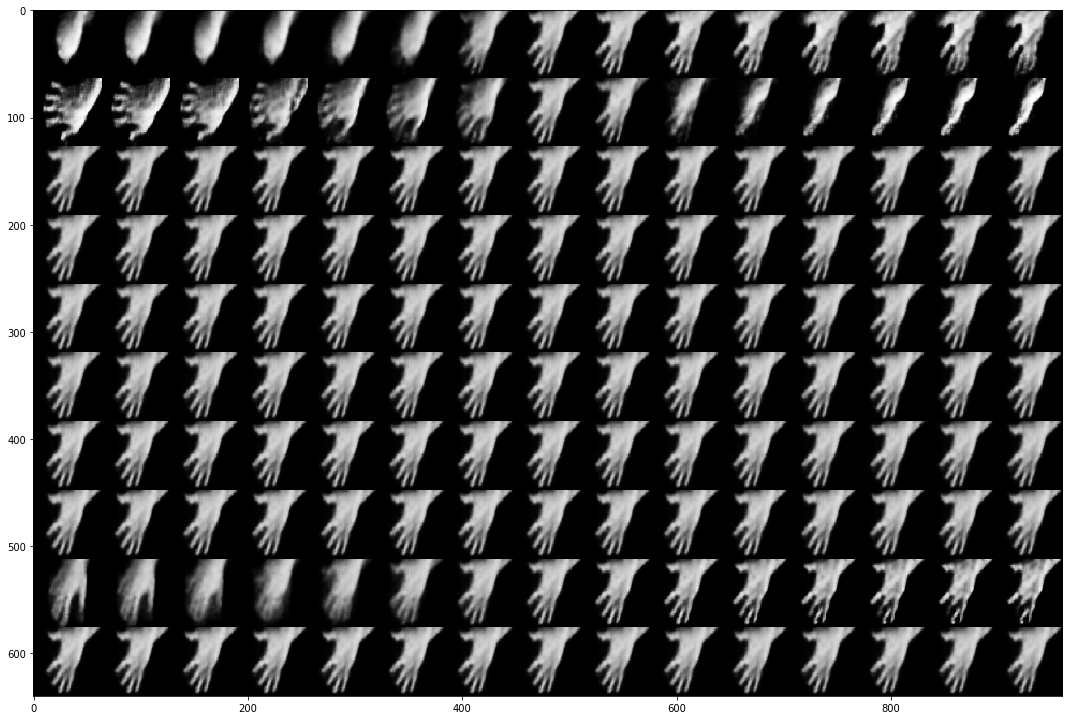

In [84]:
wahl = 700

#tf.reset_default_graph()
check_point_file = "model/modelHandConv600.ckpt"
#saver = tf.train.import_meta_graph("model/modelHandConv300.ckpt.meta")
#saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, check_point_file)
    print("Model restored.")
    
    for wahl in range(12):
        z_baseline  = sess.run((z), feed_dict={x: x_dataset[wahl*100].reshape(1,input_shape[0], input_shape[1], 1)/255})
        resultImage = sess.run((d_3Sigmoid_before_pooling), feed_dict={z: z_baseline})

        resultImage = resultImage.reshape(input_shape[0], input_shape[1])*255
        plt.imshow(resultImage, cmap=plt.get_cmap('gray'))
        plt.show()

        ######## Plotten der Latenten Eigenschaften
        nx = 15
        ny = n_z
        x_values = np.linspace(-4, 4, nx)
        canvas = np.empty((input_shape[0]*ny, input_shape[1]*nx))
        for i in range(ny):
            z_latent = z_baseline

            # Create input Matrix with altered xvalues in the i-th feature
            z_latent = np.ones((nx,ny))*z_latent
            z_latent[:,i] += x_values.transpose()

            resultImage = sess.run(d_3Sigmoid_before_pooling, feed_dict={z: z_latent})

            for canvasRow in range(nx):
                canvas[(i)*input_shape[0]:(i+1)*input_shape[1], canvasRow*input_shape[0]:(canvasRow+1)*input_shape[1]] = resultImage[canvasRow].reshape(input_shape[0], input_shape[1])

        plt.figure(figsize=(15, 15))        
        plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
        plt.tight_layout()
        plt.show()


